In [16]:
import pandas as pd
import numpy as np
import re

import numpy as np
from multiprocessing import cpu_count, Pool
 
cores = cpu_count() # Number of CPU cores on your system
partitions = cores # Define as many partitions as you want
 
def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    data = pool.map(func, data_split)
    pool.close()
    pool.join()
    return data

In [3]:
posts_df = pd.read_json('data/stackoverflow/sample/CombinedDocs.100K.Questions.jsonl.gz', lines=True)
print('Original posts: {:,}'.format(len(posts_df.index)))

Original posts: 273,876


In [4]:
tag_posts = posts_df.dropna(axis=0, subset=['_Tags'])
print('Posts w/ tags: {:,}'.format(len(tag_posts.index)))

Posts w/ tags: 98,278


In [23]:
tags = tag_posts['_Tags'].apply(lambda x: re.findall('\<(.+?)\>', x))
len(tags)

98278

In [6]:
from collections import defaultdict
# import seaborn as sns

tag_counts = defaultdict(int)

for row in tags:
    for tag in row:
        tag_counts[tag] += 1

for i in [0, 10, 20, 50, 100, 1000]:
    filtered_tags = list(filter(lambda x: x > i, tag_counts.values()))
    print('There are {:,} tags with more than {:,} count'.format(len(filtered_tags), i))
    # t = pd.Series(filtered_tags, name="Tag Count")
    # ax = sns.distplot(t)

MIN_TAGS = 50

There are 18,549 tags with more than 0 count
There are 2,730 tags with more than 10 count
There are 1,589 tags with more than 20 count
There are 709 tags with more than 50 count
There are 367 tags with more than 100 count
There are 33 tags with more than 1,000 count


In [7]:
all_tags = set()
for row in tags:
    for tag in row:
        if tag_counts[tag] > MIN_TAGS:
            all_tags.add(tag)
print('Total unique tags with {:,} occurrences: {:,}'.format(MIN_TAGS, len(all_tags)))
sorted_all_tags = sorted(all_tags)

tag_to_id = {val:i for i, val in enumerate(sorted_all_tags)}
id_to_tag = {i:val for i, val in enumerate(sorted_all_tags)}

Total unique tags with 50 occurrences: 709


In [29]:
labels = []
tag_list = tags.tolist()

# Loop through every post...
for i, tag_set in enumerate(tags.tolist()):
    # Then build a 709 element wide list for each tag present
    label_row = []
    for tag in sorted_all_tags:
        if tag in tag_list[i]:
            label_row.append(1)
        else:
            label_row.append(0)
    labels.append(label_row)
    
tag_labels = [id_to_tag[key_id] for key_id in sorted(id_to_tag.keys()) if tag_counts[id_to_tag[key_id]] > MIN_TAGS]

len(labels), len(labels[0]), len(tag_labels)

(98278, 709, 709)

In [30]:
from bs4 import BeautifulSoup

MIN_CODE = 20

def extract_code(x):
    doc = BeautifulSoup(x)
    return '\n'.join([d.text.lower() for d in doc.find_all('code')])
    
post_code_text = tag_posts._Body.apply(extract_code)
post_code_words = [x.split() for x in post_code_text.tolist()]

# Count the words for testing
code_word_counts = defaultdict(int)
all_words = set()
for post in post_code_words:
    for word in post:
        code_word_counts[word] += 1
        all_words.add(word)

sorted_all_words = sorted(all_words)
print('All words: {:,}'.format(len(sorted_all_words)))

word_to_id = {word:i for i, word in enumerate(sorted_all_words)}
id_to_word = {i:word for i, word in enumerate(sorted_all_words)} 

# Take words with > MIN_CODE (20) instances and build new label sets
encoded_posts = []
raw_labels = set()
encoded_labels = set()
for words in post_code_words:
    encoded_words = []
    for word in words:
        if code_word_counts[word] > MIN_CODE:
            encoded_words.append(word_to_id[word])
            raw_labels.add(word)
            encoded_labels.add(word_to_id[word])
    encoded_posts.append(encoded_words)

print('Filtered words: {:,}'.format(len(encoded_labels)))
    
# Remove nulls now that we filtered words
code_post_ids = defaultdict(bool)
filtered_code_words = []
for i, post in enumerate(encoded_posts):
    if len(post) < 5:
        pass
    else:
        code_post_ids[i] = True
        filtered_code_words.append(post)
        
del post_code_words
len(filtered_code_words)

All words: 1,364,058
Filtered words: 17,119


64426

In [31]:
new_labels = []
for post_id in code_post_ids.keys():
    label_set = labels[post_id]
    if code_post_ids[post_id]:
        new_labels.append(label_set)

del labels
len(new_labels)

64426

In [32]:
# Validate the posts match the labels
assert(len(filtered_code_words) == len(new_labels))
print('We are left with {:,} example posts'.format(len(filtered_code_words)))

We are left with 64,426 example posts


In [33]:


# # Make sure there are some code words
# non_null_post_ids = [i for i, e in enumerate(encoded_posts) if len(e) > 0 and max(e) == 1]

# encoded_posts = [post for i, post in enumerate(encoded_posts) if i in non_null_post_ids]
# new_labels = [label for i, label in enumerate(new_labels) if i in non_null_post_ids]

# len(encoded_posts), len(new_labels)
filtered_code_words

[[108272,
  396981,
  396981,
  321094,
  396981,
  344966,
  396981,
  354340,
  396981,
  354340,
  396981,
  283471],
 [364740,
  788081,
  380123,
  379935,
  388799,
  1276714,
  388799,
  1276717,
  741463,
  832696,
  1349469,
  1307844,
  909474,
  396981,
  968802,
  1349469,
  553790,
  968802,
  1349062,
  309491,
  911198,
  763115,
  1359973,
  1307844,
  912227,
  396981,
  968802,
  763127,
  1051135,
  968802,
  910062,
  909474,
  1359973,
  1359235,
  762582,
  161260,
  832757,
  368921,
  390686,
  1276697,
  1349469,
  775491,
  302696,
  1349469,
  775491,
  302696,
  369345,
  367163,
  373229,
  375946,
  448128,
  967398,
  375946,
  366442,
  366442,
  365733,
  367214],
 [1044971,
  388977,
  127611,
  378687,
  364871,
  127591,
  367095,
  394965,
  364871,
  1097191,
  127591,
  369858,
  388977,
  364871,
  733920,
  667257,
  1358694,
  127591,
  375946,
  568061,
  364871,
  706179,
  362030,
  127591,
  366442,
  375946,
  568061,
  364871,
  706179,
 

In [53]:
import random
random.seed(33)

SAMPLE_SIZE = len(filtered_code_words)
id_list = list(range(0, len(filtered_code_words)))
idx = random.sample(id_list, SAMPLE_SIZE)

# idx = np.random.choice(np.arange(len(matrix_posts)), SAMPLE_SIZE, replace=False)

sampled_posts = [x for i, x in enumerate(filtered_code_words) if i in idx]
sampled_labels = [x for i, x in enumerate(new_labels) if i in idx]

# del filtered_code_words
# del new_labels

len(sampled_posts), len(sampled_labels)

(64426, 64426)

In [54]:
from keras.preprocessing.sequence import pad_sequences

MAX_CODE_LENGTH = 50

padded_posts = pad_sequences(sampled_posts, MAX_CODE_LENGTH, padding='post')
padded_posts

array([[ 108272,  396981,  396981, ...,       0,       0,       0],
       [1276717,  741463,  832696, ...,  366442,  365733,  367214],
       [ 394965,  364871, 1097191, ...,  127780,  366442,  367597],
       ...,
       [ 160734, 1360044, 1349469, ...,  978592,  448128,  741463],
       [ 395425,  798565,  395425, ...,       0,       0,       0],
       [1283412,  709163, 1349469, ...,       0,       0,       0]],
      dtype=int32)

In [55]:
from sklearn.model_selection import train_test_split

TEST_SPLIT = 0.2

label_mx = np.array(sampled_labels)
X_train, X_test, y_train, y_test = train_test_split(
    padded_posts,
    label_mx,
    test_size=TEST_SPLIT,
    random_state=33
)

label_mx.shape

(64426, 709)

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

MAX_NB_WORDS = len(encoded_labels)
EMBEDDING_DIM = 50

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(709, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
from keras.callbacks import EarlyStopping

epochs = 4
batch_size = 64

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
    ]
)

Train on 46386 samples, validate on 5154 samples
Epoch 1/4
46386/46386 [==============================] - 31s 677us/step - loss: 11.7291 - acc: 0.0552 - val_loss: 11.6960 - val_acc: 0.0590
Epoch 2/4
46386/46386 [==============================] - 31s 676us/step - loss: 11.7234 - acc: 0.0552 - val_loss: 11.6926 - val_acc: 0.0580
Epoch 3/4
46386/46386 [==============================] - 31s 677us/step - loss: 11.7163 - acc: 0.0555 - val_loss: 11.6924 - val_acc: 0.0592
Epoch 4/4
46386/46386 [==============================] - 31s 677us/step - loss: 11.7117 - acc: 0.0560 - val_loss: 11.6917 - val_acc: 0.0605


In [67]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

12886/12886 [==============================] - 5s 402us/step
Test set
  Loss: 11.726
  Accuracy: 0.057


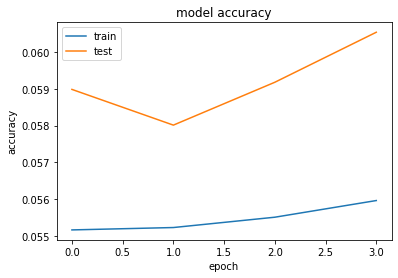

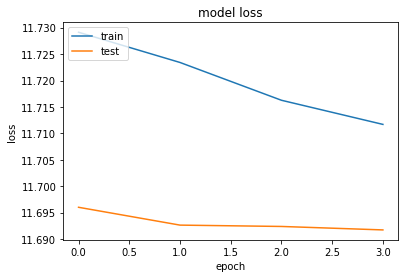

In [68]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
# See https://groups.google.com/forum/#!topic/keras-users/_sjndHbejTY
import keras.backend as K

def cross_entropy_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

def hamming_loss(y_true, y_pred):
    tmp = K.abs(y_true-y_pred)
    return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))

In [72]:
y_pred = model.predict(X_test)

cross_entropy_loss(y_test, y_pred), hamming_loss(y_test, y_pred)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'